In [5]:
import tensorflow as tf
#--------------------------------------
print(tf.__version__)
import random
random.seed(43)

# print(tf.config.list_physical_devices('GPU'))

2.2.0


In [6]:
from tensorflow.compat.v1.keras import backend as K
config =  tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.0
config.gpu_options.allow_growth = True
sess =  tf.compat.v1.Session(config=config)
K.set_session(sess)

In [7]:
from tensorflow.keras import backend as k
from tensorflow.keras.layers import Dense, Conv2D, add, BatchNormalization, Dropout, Flatten, Reshape, LeakyReLU
from tensorflow.keras.models import Model 
import cv2
import numpy as np
import pandas as pd
# from tqdm import tqdm
import os
# from google.colab import drive
from PIL import Image
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
tf.compat.v1.reset_default_graph()


In [8]:
max_age = 116

df=pd.read_csv('dataWithAUg.csv')
no_race_classes = df.race.unique().size
from sklearn.utils import shuffle
df = shuffle(df)
msk = np.random.rand(len(df)) < 0.8

train = df[msk]

valid = df[~msk]

print(len(valid)/ len( train))

0.2533775776250296


In [9]:
train.head()


,img_path,age,gender,race,Age_bin_custom_label,Age_bin_custom_range
51663,../UTKface/3_1_0_20170109192003664.jpg.chip.jpg,3.0,1,0,0,"(0, 5]"
83817,./../UTKface_aum/45_0_0_20170117155728441.jpg....,45.0,0,0,8,"(40, 45]"
82785,./../UTKface_aum/45_1_0_20170115231034803.jpg....,45.0,1,0,8,"(40, 45]"
31998,./../UTKface_aum/18_1_4_20170109212430115.jpg....,18.0,1,4,3,"(15, 20]"
65660,./../UTKface_aum/33_0_0_20170105165208905.jpg....,33.0,0,0,6,"(30, 35]"


In [10]:
q1, q3 = train.age.quantile([0.25,0.75]).to_list()
iqr = q3-q1
train.age = (train.age - q1)/iqr
valid.age = (valid.age - q1)/iqr

/home/ai/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [11]:
q1, iqr

(19.0, 35.0)

In [12]:
train.age.min(), train.age.max()

(-0.5142857142857142, 2.7714285714285714)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa31c494080>,
      dtype=object)

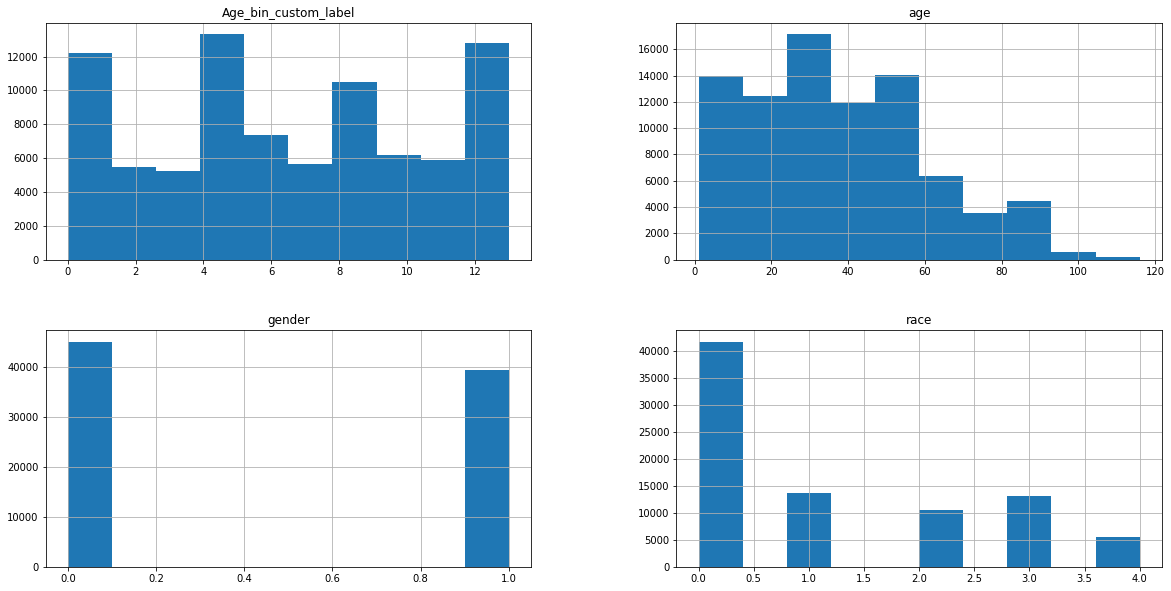

In [13]:
df.hist(figsize=(20,10))

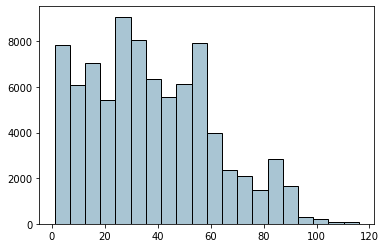

In [14]:
df.age.hist(bins=20, color='#A9C5D3', edgecolor='black',  
                          grid=False)

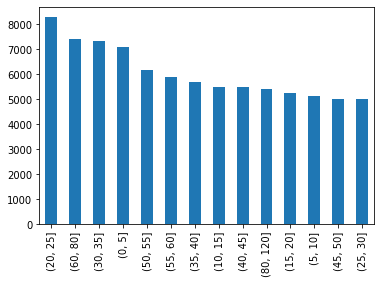

In [15]:
pd.value_counts(df['Age_bin_custom_range']).plot.bar()

In [16]:
def gen(df, batch_size = 100, w=160, h=160):
  df = df.reset_index()
  
  while True:
    samples_range = len(df)//batch_size
    for i in range(samples_range) :
      start = i * batch_size
      end = start + batch_size
      y = [
            np.array(df['age'].loc[start:end-1]), 
            np.array(df['gender'].loc[start:end-1]), 
            np.array(df['race'].loc[start:end-1])
          ]
      x =[]
      for j in range (start, end):
        img = cv2.imread(df.loc[j]['img_path'],cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img =cv2.resize(img, (w,h) )
        x.append(img)
      x = np.array(x)/255.0
      yield x, y

In [17]:
g_train = gen(train, batch_size = 20)

In [18]:
x, y = next(g_train) 

In [19]:
x.shape

(20, 160, 160, 3)

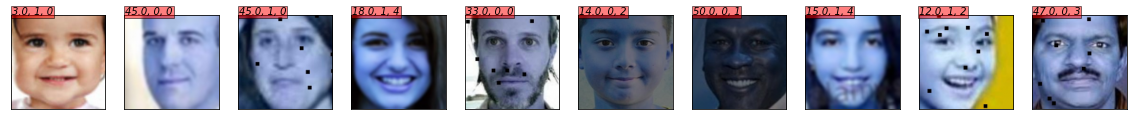

In [20]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(0, n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x[i])
    ax.text(0.95, 0.01, '{}, {}, {}'.format(np.round((y[0][i]*iqr+q1),3), y[1][i], y[2][i]), style='italic',
    bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 1})

    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [18]:
facenet = tf.keras.models.load_model('../pretrained_models/facenet_keras.h5')
# summarize input and output shape
print(facenet.inputs)
print(facenet.outputs)

[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/Identity:0' shape=(None, 128) dtype=float32>]


In [19]:
for i in range(len(facenet.layers)):
    facenet.layers[i].trainable = False

In [20]:
# build base model
img_input = facenet.input
base_model = facenet.output
base_model = tf.keras.layers.Dense(1024,activation='linear')(base_model)
#------------------------------- Age Model ----------------------------------------
age_base = tf.keras.layers.Dense(128,activation='relu')(base_model)
age_base = tf.keras.layers.Dropout(0.2)(age_base)
age_base = tf.keras.layers.BatchNormalization()(age_base)
age_base = tf.keras.layers.Dense(96,activation='relu')(age_base)
age_base = tf.keras.layers.Dropout(0.2)(age_base)
age_base = tf.keras.layers.BatchNormalization()(age_base)
age_base = tf.keras.layers.Dense(32,activation='relu')(age_base)
age_base = tf.keras.layers.Dropout(0.2)(age_base)
age_base = tf.keras.layers.BatchNormalization()(age_base)
age_base = tf.keras.layers.Dense(1,activation='linear',name='age_out')(age_base)
age_model = tf.keras.models.Model(img_input, age_base)
#---------------------------------------------------------------------
gender_base = tf.keras.layers.Dense(128,activation='relu')(base_model)
gender_base = tf.keras.layers.Dropout(0.2)(gender_base)
gender_base = tf.keras.layers.BatchNormalization()(gender_base)
gender_base = tf.keras.layers.Dense(96,activation='relu')(gender_base)
gender_base = tf.keras.layers.Dropout(0.2)(gender_base)
gender_base = tf.keras.layers.BatchNormalization()(gender_base)
gender_base = tf.keras.layers.Dense(32,activation='relu')(gender_base)
gender_base = tf.keras.layers.Dropout(0.2)(gender_base)
gender_base = tf.keras.layers.BatchNormalization()(gender_base)
gender_base = tf.keras.layers.Dense(1,activation='sigmoid',name='gender_out')(gender_base)
gender_model = tf.keras.models.Model(img_input, gender_base)
#---------------------------------------------------------------------
race_base = tf.keras.layers.Dense(128,activation='relu')(base_model)
race_base = tf.keras.layers.Dropout(0.2)(race_base)
race_base = tf.keras.layers.BatchNormalization()(race_base)
race_base = tf.keras.layers.Dense(96,activation='relu')(race_base)
race_base = tf.keras.layers.Dropout(0.2)(race_base)
race_base = tf.keras.layers.BatchNormalization()(race_base)
race_base = tf.keras.layers.Dense(32,activation='relu')(race_base)
race_base = tf.keras.layers.Dropout(0.2)(race_base)
race_base = tf.keras.layers.BatchNormalization()(race_base)
race_base = tf.keras.layers.Dense(no_race_classes,activation='softmax',name='race_out')(race_base)
race_model = tf.keras.models.Model(img_input, race_base)
#---------------------------------------------------------------------
model = tf.keras.models.Model(inputs=[img_input], outputs=[age_base, gender_base, race_base])
model.compile(optimizer='Adam', loss=['mae', 'binary_crossentropy', 'sparse_categorical_crossentropy'], metrics=['acc'])
# model.summary()

In [21]:
import datetime
model = tf.keras.models.load_model('../logs/models/model_AGR_facenet_v2.h5')
model.compile(optimizer='Adam', loss=['mae', 'binary_crossentropy', 'sparse_categorical_crossentropy'], metrics=['acc'])

RUN_NAME = 'model_AGR_facenet_v2'

ReduceLROnPlateau =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, mode='min',min_delta=0.0009)  
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('..','logs','models','{}.h5'.format(RUN_NAME)), 
                                                                    save_best_only=True, verbose=1,mode='min') # 'model1.{epoch:02d}-{val_loss:.2f}.h5'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join('..','logs', 'fit'), histogram_freq=1)
# Create EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.001, patience=50, restore_best_weights=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join('..','logs','csv_logger','{}.csv'.format(RUN_NAME)), separator=',', append=True)
callbacks = [early_stopping, tensorboard_callback, csv_logger, checkpoint,ReduceLROnPlateau]
facenet

In [23]:

epoches = 100
batch_size = 64
steps_per_epoch = len(train)//batch_size
validation_steps = len(valid)//batch_size
train_set = gen(train, batch_size = batch_size)
valid_set = gen(valid, batch_size = batch_size)
hist = model.fit(train_set,steps_per_epoch=steps_per_epoch,
                  validation_data = valid_set, validation_steps = validation_steps,
                 initial_epoch =13,epochs=epoches, shuffle=True, callbacks=callbacks, verbose=1)

Epoch 14/100
1054/1054 [==============================] - ETA: 0s - loss: 0.9989 - age_out_loss: 0.2087 - gender_out_loss: 0.2393 - race_out_loss: 0.5508 - age_out_acc: 0.0247 - gender_out_acc: 0.8934 - race_out_acc: 0.8129
Epoch 00014: val_loss improved from inf to 0.89319, saving model to ../logs/models/model_AGR_facenet_v2.h5
1054/1054 [==============================] - 165s 157ms/step - loss: 0.9989 - age_out_loss: 0.2087 - gender_out_loss: 0.2393 - race_out_loss: 0.5508 - age_out_acc: 0.0247 - gender_out_acc: 0.8934 - race_out_acc: 0.8129 - val_loss: 0.8932 - val_age_out_loss: 0.1746 - val_gender_out_loss: 0.2199 - val_race_out_loss: 0.4987 - val_age_out_acc: 0.0256 - val_gender_out_acc: 0.9046 - val_race_out_acc: 0.8226 - lr: 0.0010
Epoch 15/100
1054/1054 [==============================] - ETA: 0s - loss: 0.9887 - age_out_loss: 0.2077 - gender_out_loss: 0.2379 - race_out_loss: 0.5432 - age_out_acc: 0.0247 - gender_out_acc: 0.8957 - race_out_acc: 0.8147
Epoch 00015: val_loss impro

In [47]:
# tf.compat.v1.reset_default_graph()

model = tf.keras.models.load_model('../logs/models/model_AGR_facenet_v2.h5')
opt = tf.keras.optimizers.Adam(learning_rate=0.0009)
model.compile(optimizer=opt, loss=['mae', 'binary_crossentropy', 'sparse_categorical_crossentropy'], metrics=['acc'])


In [49]:
# freez pretrained layers
for i in range(len(model.layers)):
   # if  not isinstance(model.layers[i], tf.keras.layers.BatchNormalization):
        #print(model.layers[i].trainable)
        model.layers[i].trainable = True

In [50]:
import datetime
RUN_NAME = 'model_AGR_facenet_trainable_v2'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('..','logs','models','{}.h5'.format(RUN_NAME)), 
                                                                      save_best_only=True, verbose=1) # 'model1.{epoch:02d}-{val_loss:.2f}.h5'
ReduceLROnPlateau =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, mode='min',min_delta=0.0009)  
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('..','logs','models','{}.h5'.format(RUN_NAME)), 
                                                                    save_best_only=True, verbose=1,mode='min') # 'model1.{epoch:02d}-{val_loss:.2f}.h5'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join('..','logs', 'fit'), histogram_freq=1)
# Create EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.001, patience=50, restore_best_weights=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join('..','logs','csv_logger','{}.csv'.format(RUN_NAME)), separator=',', append=True)
callbacks = [early_stopping, tensorboard_callback, csv_logger, checkpoint,ReduceLROnPlateau]


In [51]:
epoches = 100
batch_size = 32
steps_per_epoch = len(train)//batch_size
validation_steps = len(valid)//batch_size
train_set = gen(train, batch_size = batch_size)
valid_set = gen(valid, batch_size = batch_size)
hist = model.fit(train_set,steps_per_epoch=steps_per_epoch,
                  validation_data = valid_set, validation_steps = validation_steps,
                 initial_epoch =0,epochs=epoches, shuffle=True, callbacks=callbacks, verbose=1)

Epoch 1/100
2109/2109 [==============================] - ETA: 0s - loss: 0.8852 - age_out_loss: 0.2060 - gender_out_loss: 0.2008 - race_out_loss: 0.4784 - age_out_acc: 0.0246 - gender_out_acc: 0.9117 - race_out_acc: 0.8321
Epoch 00001: val_loss improved from inf to 0.78771, saving model to ../logs/models/model_AGR_facenet_trainable_v2.h5
2109/2109 [==============================] - 165s 78ms/step - loss: 0.8852 - age_out_loss: 0.2060 - gender_out_loss: 0.2008 - race_out_loss: 0.4784 - age_out_acc: 0.0246 - gender_out_acc: 0.9117 - race_out_acc: 0.8321 - val_loss: 0.7877 - val_age_out_loss: 0.1603 - val_gender_out_loss: 0.1892 - val_race_out_loss: 0.4382 - val_age_out_acc: 0.0255 - val_gender_out_acc: 0.9172 - val_race_out_acc: 0.8411 - lr: 9.0000e-04
Epoch 2/100
2109/2109 [==============================] - ETA: 0s - loss: 0.8889 - age_out_loss: 0.2066 - gender_out_loss: 0.2040 - race_out_loss: 0.4783 - age_out_acc: 0.0246 - gender_out_acc: 0.9107 - race_out_acc: 0.8306
Epoch 00002: val

In [66]:
def pred_transform(pred):
    iqr, q1 = 22, 23
    pred[0] = np.round((pred[0] * iqr)+q1, 0).astype('int')
    pred[1] = pred[1]>0.5
    pred[2] = np.argmax(pred[2], axis=1).reshape(-1,1)
    
    pred_dict = {'age':list(pred[0].ravel()), 'gender':list(pred[1].ravel()), 'race':list(pred[2].ravel())}
    pred_df = pd.DataFrame(pred_dict)
    pred_df.gender.replace(True, 'F', inplace=True)
    pred_df.gender.replace(False, 'M', inplace=True)
    pred_df.race.replace(0, 'US/EU', inplace=True)
    pred_df.race.replace(1, 'African', inplace=True)
    pred_df.race.replace(2, 'Asian', inplace=True)
    pred_df.race.replace(3, 'Indean', inplace=True)
    pred_df.race.replace(4, 'Other', inplace=True)
    
    return pred, pred_df


# Xception


In [62]:
Xception = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(160, 160, 3),
)
# build base model
img_input = Xception.input
base_model = Xception.output
base_model = tf.keras.layers.Flatten()(base_model)
base_model = tf.keras.layers.Dense(1024,activation='linear')(base_model)
#------------------------------- Age Model ----------------------------------------
age_base = tf.keras.layers.Dense(128,activation='relu')(base_model)
age_base = tf.keras.layers.Dropout(0.2)(age_base)
age_base = tf.keras.layers.BatchNormalization()(age_base)
age_base = tf.keras.layers.Dense(96,activation='relu')(age_base)
age_base = tf.keras.layers.Dropout(0.2)(age_base)
age_base = tf.keras.layers.BatchNormalization()(age_base)
age_base = tf.keras.layers.Dense(32,activation='relu')(age_base)
age_base = tf.keras.layers.Dropout(0.2)(age_base)
age_base = tf.keras.layers.BatchNormalization()(age_base)
age_base = tf.keras.layers.Dense(1,activation='linear',name='age_out')(age_base)
age_model = tf.keras.models.Model(img_input, age_base)
#---------------------------------------------------------------------
gender_base = tf.keras.layers.Dense(128,activation='relu')(base_model)
gender_base = tf.keras.layers.Dropout(0.2)(gender_base)
gender_base = tf.keras.layers.BatchNormalization()(gender_base)
gender_base = tf.keras.layers.Dense(96,activation='relu')(gender_base)
gender_base = tf.keras.layers.Dropout(0.2)(gender_base)
gender_base = tf.keras.layers.BatchNormalization()(gender_base)
gender_base = tf.keras.layers.Dense(32,activation='relu')(gender_base)
gender_base = tf.keras.layers.Dropout(0.2)(gender_base)
gender_base = tf.keras.layers.BatchNormalization()(gender_base)
gender_base = tf.keras.layers.Dense(1,activation='sigmoid',name='gender_out')(gender_base)
gender_model = tf.keras.models.Model(img_input, gender_base)
#---------------------------------------------------------------------
race_base = tf.keras.layers.Dense(128,activation='relu')(base_model)
race_base = tf.keras.layers.Dropout(0.2)(race_base)
race_base = tf.keras.layers.BatchNormalization()(race_base)
race_base = tf.keras.layers.Dense(96,activation='relu')(race_base)
race_base = tf.keras.layers.Dropout(0.2)(race_base)
race_base = tf.keras.layers.BatchNormalization()(race_base)
race_base = tf.keras.layers.Dense(32,activation='relu')(race_base)
race_base = tf.keras.layers.Dropout(0.2)(race_base)
race_base = tf.keras.layers.BatchNormalization()(race_base)
race_base = tf.keras.layers.Dense(no_race_classes,activation='softmax',name='race_out')(race_base)
race_model = tf.keras.models.Model(img_input, race_base)
#---------------------------------------------------------------------
Xception = tf.keras.models.Model(inputs=[img_input], outputs=[age_base, gender_base, race_base])
Xception.compile(optimizer='Adam', loss=['mae', 'binary_crossentropy', 'sparse_categorical_crossentropy'], metrics=['acc'])
# model.summary()

In [63]:
import datetime
# Xception = tf.keras.models.load_model('../logs/models/model_xception_AGR_cropped.h5')
Xception.compile(optimizer='Adam', loss=['mae', 'binary_crossentropy', 'sparse_categorical_crossentropy'], metrics=['acc'])

RUN_NAME = 'model_xception_AGR_cropped_v3'

ReduceLROnPlateau =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, mode='min',min_delta=0.0009)  
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('..','logs','models','{}.h5'.format(RUN_NAME)), 
                                                                    save_best_only=True, verbose=1,mode='min') # 'model1.{epoch:02d}-{val_loss:.2f}.h5'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join('..','logs', 'fit'), histogram_freq=1)
# Create EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.001, patience=50, restore_best_weights=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join('..','logs','csv_logger','{}.csv'.format(RUN_NAME)), separator=',', append=True)
callbacks = [early_stopping, tensorboard_callback, csv_logger, checkpoint,ReduceLROnPlateau]


In [65]:

epoches = 100
batch_size = 64
steps_per_epoch = len(train)//batch_size
validation_steps = len(valid)//batch_size
train_set = gen(train, batch_size = batch_size)
valid_set = gen(valid, batch_size = batch_size)
hist = Xception.fit(train_set,steps_per_epoch=steps_per_epoch,
                  validation_data = valid_set, validation_steps = validation_steps,
                 initial_epoch =0,epochs=epoches, shuffle=True, callbacks=callbacks, verbose=1)

Epoch 1/100
1054/1054 [==============================] - ETA: 0s - loss: 1.5525 - age_out_loss: 0.3943 - gender_out_loss: 0.2972 - race_out_loss: 0.8610 - age_out_acc: 0.0206 - gender_out_acc: 0.8671 - race_out_acc: 0.6967
Epoch 00001: val_loss improved from inf to 0.94667, saving model to ../logs/models/model_xception_AGR_cropped_v3.h5
1054/1054 [==============================] - 324s 307ms/step - loss: 1.5525 - age_out_loss: 0.3943 - gender_out_loss: 0.2972 - race_out_loss: 0.8610 - age_out_acc: 0.0206 - gender_out_acc: 0.8671 - race_out_acc: 0.6967 - val_loss: 0.9467 - val_age_out_loss: 0.2173 - val_gender_out_loss: 0.2339 - val_race_out_loss: 0.4955 - val_age_out_acc: 0.0239 - val_gender_out_acc: 0.9012 - val_race_out_acc: 0.8318 - lr: 0.0010
Epoch 2/100
1054/1054 [==============================] - ETA: 0s - loss: 0.8143 - age_out_loss: 0.2129 - gender_out_loss: 0.1519 - race_out_loss: 0.4495 - age_out_acc: 0.0248 - gender_out_acc: 0.9413 - race_out_acc: 0.8554
Epoch 00002: val_los

In [64]:
for i in range(len(Xception.layers)):
    Xception.layers[i].trainable = True

# facenet predict

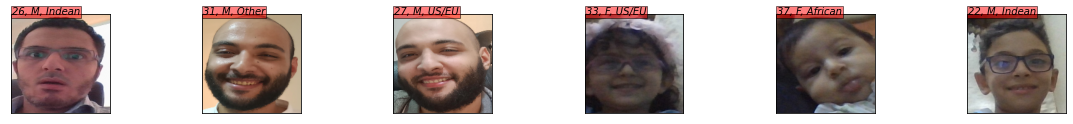

In [67]:
test_imgs = glob('../dataset/test_imgs/*')
x = []
for i in range(len(test_imgs)):
#     im =Image.open(test_imgs[i]).resize((160,160))
    im = cv2.resize(cv2.imread(test_imgs[i]), (160, 160))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    x.append(im)

x = np.array(x)/255.0

pred = model.predict(x)
_, pred = pred_transform(pred)

n = len(test_imgs)  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(0, n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x[i])
    ax.text(0.95, 0.01, '{}, {}, {}'.format(pred.age.loc[i], pred.gender.loc[i], pred.race.loc[i]), style='italic',
    bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 1})

    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()